## UnSu Unet Object Localization

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import datetime


import numpy as np
import matplotlib.pyplot as plt

In [31]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [32]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available")
    
    # Clear GPU memory
    K.clear_session()
    tf.config.experimental.reset_memory_stats('GPU:0')

In [33]:
# Import custom functions to extract Image arrays and Pixel Mask arrays from our created fits files dataset
from dataGathering import extractImageArray, extractPixelMaskArray, extract_star_catalog
from dataGathering import getStarData, getImagePlot, getPixelMaskPlot
from dataGathering import displayRawImage, displayRawPixelMask, displayImagePlot, displayPixelMaskPlot, displayPixelMaskOverlayPlot

# Import custom function to preprocess Image and Pixel Mask arrays
from imageProcessing import normalizeImages, stackImages, stackMasks, preprocessImage

# Import astropy to read fits files, and os to interact with the file system
from astropy.io import fits
import os

In [34]:
# getStarData('II/246', 25, 'data')

In [35]:
# Create images and masks arrays lists
images = []
masks = []

# Create df to store the star data inside each fits file
star_data = []

# Create a list of all the fits files in the dataset folder
fits_files = os.listdir('data/fits/')

# For all the fits files in the dataset folder specified in file_path, extract the image and mask arrays to the respective lists
file_path = 'data/fits/'
# for file in os.listdir(file_path):
for file in os.listdir(file_path):
    if file.endswith('.png'):
        os.remove(file_path + file)
    if file.startswith('data') and file.endswith('.fits'):
        images.append(extractImageArray(file_path + file))
        masks.append(extractPixelMaskArray(file_path + file))
        star_data.append(extract_star_catalog(file_path + file))

        print(file + ' added to dataset')

data7.fits added to dataset
data4.fits added to dataset
data13.fits added to dataset
data15.fits added to dataset
data24.fits added to dataset
data19.fits added to dataset
data23.fits added to dataset
data14.fits added to dataset
data16.fits added to dataset
data8.fits added to dataset
data21.fits added to dataset
data9.fits added to dataset
data22.fits added to dataset
data5.fits added to dataset
data12.fits added to dataset
data17.fits added to dataset
data20.fits added to dataset
data0.fits added to dataset
data18.fits added to dataset
data2.fits added to dataset
data6.fits added to dataset
data1.fits added to dataset
data10.fits added to dataset
data3.fits added to dataset
data11.fits added to dataset


In [36]:
masks[0].shape

(512, 512)

In [37]:
# displayImagePlot(file_path + fits_files[0])

In [38]:
# displayRawImage(file_path + fits_files[0])

In [39]:
# displayRawPixelMask(file_path + fits_files[0])

In [40]:
# displayPixelMaskPlot(file_path + fits_files[0])

In [41]:
# displayPixelMaskOverlayPlot(file_path + fits_files[0])

# Prepare the data for training

In [42]:
#############################################

# Define the test size
image_parameters = {
    'test_size': 0.2,
    'random_state': 0,
    'seed': 42
}

images[0].shape

(512, 512)

## PreProcess images

Using a number of techniques from OpenCV we prepare the images for easier training by our ML model
- convert_to_grayscale
- apply_gaussian_blur
- normalize_image
- apply_threshold
- apply_morphological_operations
- normalize_image

In [43]:
images[0].ndim


2

### Convert to 3-Channel Images

The images we have are 512 x 512 pixels, but our model requires them to be in the shape `(512, 512, 3)`, similar to standard RGB images. To achieve this, we stack the single-channel images along the last axis three times, converting them into 3-channel images. This transformation is necessary because the model typically expects 3-channel input images.

For the masks, the model expects them to be in the shape `(512, 512, 1)`. Therefore, we expand the masks along the last axis to add a new dimension, ensuring they have the correct shape.

Additionally, both the images and masks need to be converted to NumPy arrays, as this is the desired format for the training model. Below, we perform these conversions to ensure the data is in the correct format for training.

Notice when displaying the shape of the `train_images` list below we see it is an array of 10 images of the shape mentioned above, giving us a shape `(10, 512, 512, 3)`

In [44]:
# # Convert to 3-channel images,   Copilot advises the above (axis=-1) is the correct way to stack the images and masks, if incorrect do below:
# ## "For most convolutional neural networks (CNNs), the expected input shape for images is typically (height, width, channels). Therefore, you should aim to have each image in the shape (512, 512, 3)" ##
# train_images = np.array([np.stack([image, image, image], axis=-1) for image in images])
# train_masks = np.array([np.expand_dims(mask, axis=-1) for mask in masks])

# #### If the above code does not work, use the below code to stack the images and masks
# # train_images = np.array([np.stack([image, image, image], axis=0) for image in images])
# # train_masks = np.array([np.stack([mask, mask, mask], axis=0) for mask in masks])



# # Convert the list to a NumPy array,   Copilot advises that model training desired 
# ## "The model training or validation typically expects a NumPy array of images. The ImageDataGenerator from Keras can accept NumPy arrays as input" ##
# train_images = np.array(train_images)
# train_masks = np.array(train_masks)


# print(train_images[0].shape)
# print(train_images.shape)
# print(type(train_images))


In [45]:
stacked_images = stackImages(images)
stacked_masks = stackMasks(masks)

print(stacked_images[0].shape)
print(stacked_images.shape)
print(type(stacked_images))

(512, 512, 3)
(25, 512, 512, 3)
<class 'numpy.ndarray'>


In [46]:
# Show the first lines in the first train_images image array
stacked_images[0][0:1]

array([[[3201., 3201., 3201.],
        [3276., 3276., 3276.],
        [3126., 3126., 3126.],
        ...,
        [3159., 3159., 3159.],
        [2859., 2859., 2859.],
        [3084., 3084., 3084.]]], dtype=float32)

### Normalize the Images

To standardize the pixel values in our images, we need to normalize them to a common range. Typically, pixel values range from 0 to 255, and normalization is done by dividing each pixel value by 255. However, our images have pixel values that exceed this range.

Therefore, we will use min-max normalization to scale the pixel values to a range between 0.0 and 1.0. This involves finding the minimum and maximum pixel values in our dataset and then applying the following formula to each pixel:

\[ \text{normalized\_pixel} = \frac{\text{pixel} - \text{min\_value}}{\text{max\_value} - \text{min\_value}} \]

This process ensures that all pixel values are standardized, making the data suitable for input into our machine learning model.

In [47]:
# # Find the minimum and maximum values in the dataset
# min_val = np.min(train_images)
# max_val = np.max(train_images)

# # Apply min-max normalization
# train_images_normalized = (train_images - min_val) / (max_val - min_val)

# print(train_images_normalized.min(), train_images_normalized.max())  # Should be 0.0 and 1.0

In [48]:
normalized_images = normalizeImages(stacked_images)

0.0 1.0


In [49]:
# Show the first lines in the first train_images_normalized image array
normalized_images[0][0:1]

array([[[0.15383467, 0.15383467, 0.15383467],
        [0.15756491, 0.15756491, 0.15756491],
        [0.15010445, 0.15010445, 0.15010445],
        ...,
        [0.15174575, 0.15174575, 0.15174575],
        [0.13682483, 0.13682483, 0.13682483],
        [0.14801551, 0.14801551, 0.14801551]]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [435.0..18646.0].


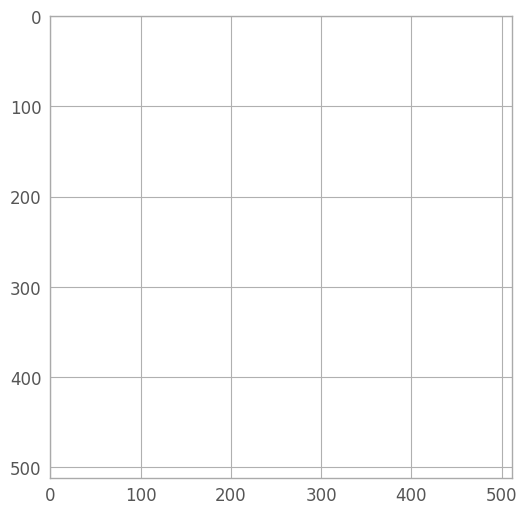

In [50]:
# Plot train_images[0][0:1]
plt.imshow(stacked_images[0])
plt.show()

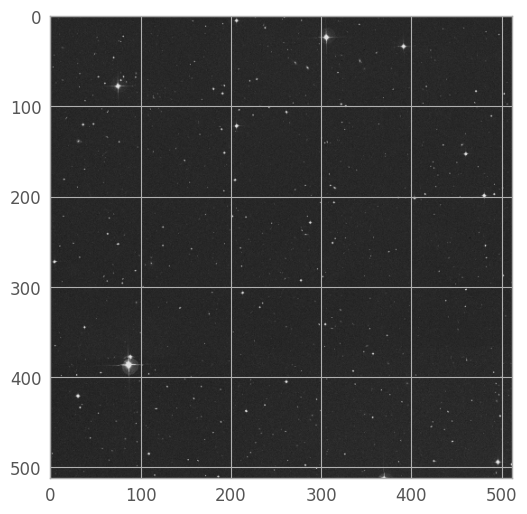

In [51]:
# Plot train_images_normalized[0][0:1]
plt.imshow(normalized_images[0])
plt.show()

In [52]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(normalized_images, stacked_masks, test_size=image_parameters['test_size'], random_state=image_parameters['random_state'])


### Create `ImageDataGenerator` Instances

1. **Create `ImageDataGenerator` for Training Images**: Apply data augmentation.
2. **Create `ImageDataGenerator` for Validation Images**: No data augmentation.
3. **Create `ImageDataGenerator` for Training Masks**: No data augmentation.
4. **Create `ImageDataGenerator` for Validation Masks**: No data augmentation.

In [53]:
# Create an ImageDataGenerator for train_image_datagen with data augmentation in order to increase the diversity of the training set
train_image_datagen = ImageDataGenerator(
    # rescale=1./255,   # No rescale needed as we have already normalized the images
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use ImageDataGenerator to load data in batches
# Create an ImageDataGenerator for validation images without data augmentation
val_image_datagen = ImageDataGenerator()

# Create an ImageDataGenerator for training masks without data augmentation
train_mask_datagen = ImageDataGenerator()

# Create an ImageDataGenerator for validation masks without data augmentation
val_mask_datagen = ImageDataGenerator()
####### generators are set again later after hyperparameters are defined #######


# Show distribution of training and validation sets
print('Training images: ', train_images.shape)
print('Training masks: ', train_masks.shape)
print('Validation images: ', val_images.shape)
print('Validation masks: ', val_masks.shape)

Training images:  (20, 512, 512, 3)
Training masks:  (20, 512, 512, 1)
Validation images:  (5, 512, 512, 3)
Validation masks:  (5, 512, 512, 1)


In [54]:
# Encoder path
    #32 kernels
    #3x3 kernel size
    #padding = same considers edges in the input
# Example function to create a U-Net model
def unet_model(input_shape, filters, kernel_size, activation, padding, initializer):
    inputs = layers.Input(input_shape)

    # Encoder path
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(inputs)
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p1)
    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p2)
    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p3)
    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p4)
    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c5)

    # Decoder path
    u6 = layers.Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding=padding)(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u6)
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c6)

    u7 = layers.Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding=padding)(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u7)
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c7)

    u8 = layers.Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding=padding)(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u8)
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c8)

    u9 = layers.Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding=padding)(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u9)
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [55]:
# Prepare the model for training
#############################################

# Define the base exponent
base_exponent = 5
#############################################
# base_exponent = 5, so filters result in [32, 64, 128, 256, 512], this was the original value
# base_exponent = 6, so filters result in [64, 128, 256, 512, 1024]
# base_exponent = 7, so filters result in [128, 256, 512, 1024, 2048]
# base_exponent = 8, so filters result in [256, 512, 1024, 2048, 4096]
# base_exponent = 9, so filters result in [512, 1024, 2048, 4096, 8192]
# base_exponent = 10, so filters result in [1024, 2048, 4096, 8192, 16384]

# Generate the filters based on powers of 2
filters = [2 ** (base_exponent + i) for i in range(5)]
#############################################
# This list comprehension generates the filter sizes by raising 2 to the powers starting from the base exponent and increasing by 1 for each subsequent filter.
#############################################

# Enable mixed precision training
# Mixed precision training can help reduce memory usage and speed up training by using both 16-bit and 32-bit floating point types.
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define hyperparameters
hyperparameters = {
    'input_shape': (512, 512, 3),
    'filters': filters,
    'kernel_size': (3, 3),
    'activation': 'relu',
    'padding': 'same',
    # 'initializer': he_uniform(),
    'initializer': he_uniform,
    'optimizer': 'adam',
    # 'loss': weightedBinaryCrossEntropy,
    'loss': 'binary_crossentropy',
    'weights' : {0 : 1.0, 1 : 10.0},
    'metrics': ['accuracy'],
    'epochs': 1,
    'batch_size': 4,
    'validation_split': image_parameters['test_size'],
    'early_stopping_patience': 10
}

# Create and compile the model using hyperparameters
model = unet_model(
    input_shape=hyperparameters['input_shape'],
    filters=hyperparameters['filters'],
    kernel_size=hyperparameters['kernel_size'],
    activation=hyperparameters['activation'],
    padding=hyperparameters['padding'],
    initializer=hyperparameters['initializer']
)
model.compile(
    optimizer=hyperparameters['optimizer'],
    loss=hyperparameters['loss'],
    metrics=hyperparameters['metrics']
)

**Create Generators for Training and Validation**:
   - Use the `flow` method to create generators for training and validation images and masks.
   - Ensure that the `seed` parameter is the same for both image and mask generators to maintain alignment.

7. **Custom Generator**:
   - Define a custom generator function `custom_generator` that yields batches of images and masks together.
   - Use `zip` to combine the image and mask generators for both training and validation.

In [56]:
train_masks.shape

(20, 512, 512, 1)

In [57]:
# Create generators for training and validation images
train_image_generator = train_image_datagen.flow(
    train_images, batch_size=hyperparameters['batch_size'], seed=image_parameters['seed']
)

val_image_generator = val_image_datagen.flow(
    val_images, batch_size=hyperparameters['batch_size'], seed=image_parameters['seed']
)

# Create generators for training and validation masks
train_mask_generator = train_mask_datagen.flow(
    train_masks, batch_size=hyperparameters['batch_size'], seed=image_parameters['seed']
)

val_mask_generator = val_mask_datagen.flow(
    val_masks, batch_size=hyperparameters['batch_size'], seed=image_parameters['seed']
)

# Custom generator to yield images and masks together
def custom_generator(image_generator, mask_generator):
    while True:
        image_batch = next(image_generator)
        mask_batch = next(mask_generator)
        yield (image_batch, mask_batch)

# Combine the image and mask generators
train_generator = custom_generator(train_image_generator, train_mask_generator)
val_generator = custom_generator(val_image_generator, val_mask_generator)

# Train the model

In [58]:
# Train the model
#############################################

from sklearn.utils import class_weight

#############################################

# Implement Early stopping to cut useless epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric like 'val_accuracy'
    patience=hyperparameters['early_stopping_patience'],         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores the model to the best state after stopping
)

# Train the model
history = model.fit(train_images, train_masks, 
                    validation_data=(val_images, val_masks), 
                    epochs=hyperparameters['epochs'], 
                    batch_size=hyperparameters['batch_size'],
                    callbacks=[early_stopping],
                    class_weight=hyperparameters['weights'])

# Train the model
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    epochs=hyperparameters['epochs'],
                    steps_per_epoch=len(train_images) // hyperparameters['batch_size'],
                    validation_steps=len(val_images) // hyperparameters['batch_size'],
                    callbacks=[early_stopping])

ValueError: `class_weight` not supported for 3+ dimensional targets.

: 

In [32]:
# Save the model
saved_models_path = 'models/saved_models/'
training_size = str(len(train_images))
saved_model_name = datetime.datetime.now().strftime("%Y_%m_%d-%H%M_") + training_size + '_unet_model.keras'
model.save(saved_models_path + saved_model_name)

In [ ]:
# Show training loss and validation loss
print('Training loss: ', history.history['loss'][-1])
print('Validation loss: ', history.history['val_loss'][-1])

# Show training accuracy and validation accuracy
print('Training accuracy: ', history.history['accuracy'][-1])
print('Validation accuracy: ', history.history['val_accuracy'][-1])

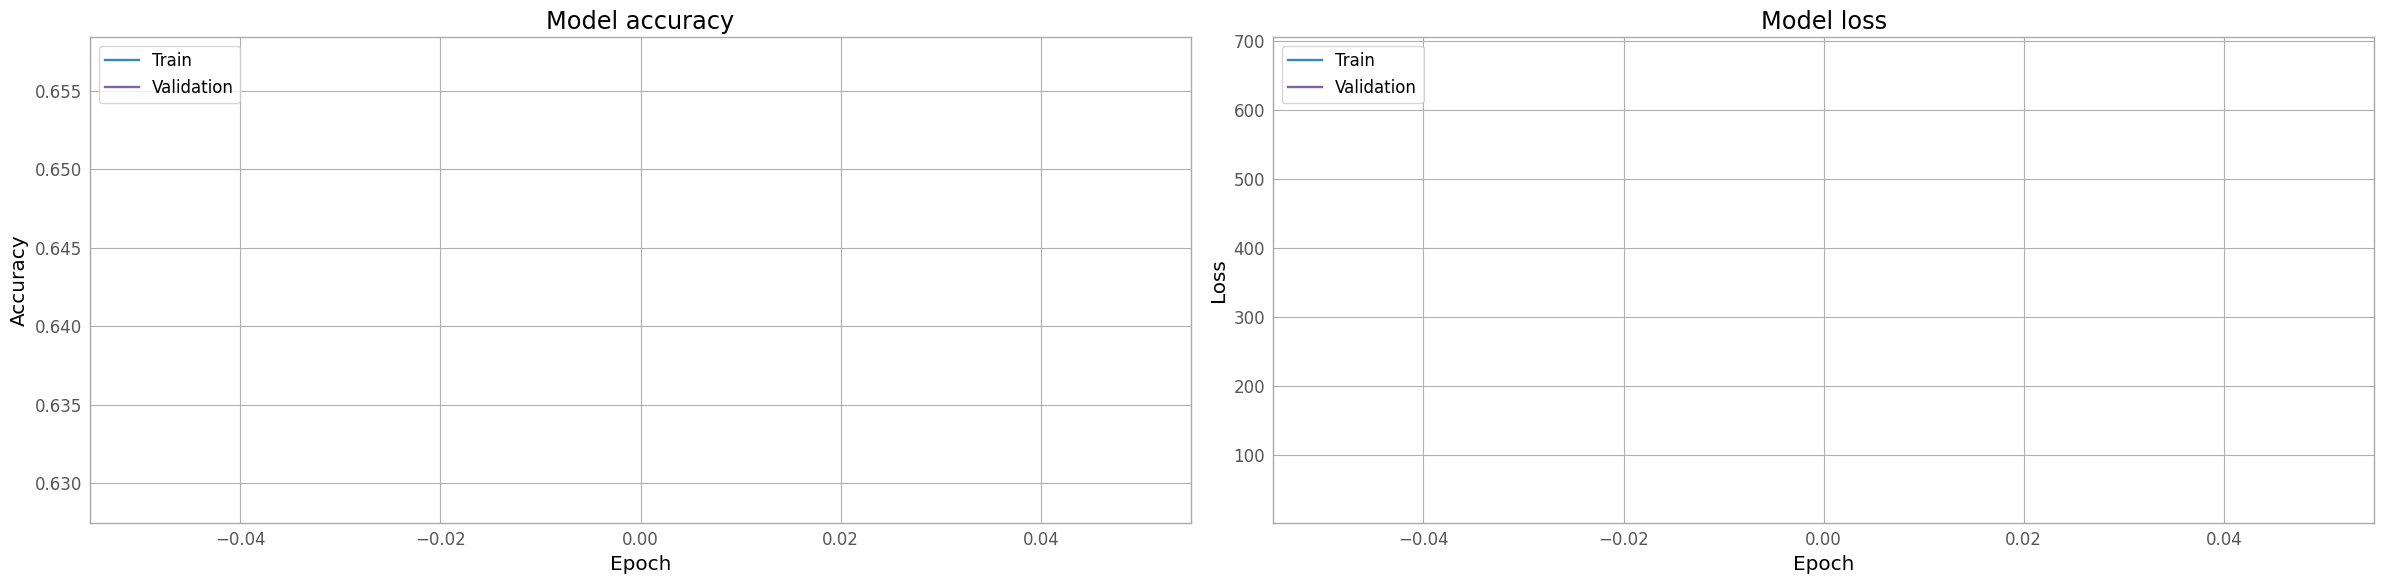

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('results/figures/' + saved_model_name.removesuffix('unet_model.keras') + '_training_validation.png')
plt.show()

In [30]:
# Save the model
model.save('150unet_model.keras')

C:\Users\shoulau\AppData\Local\Temp\ipykernel_28896\4178150593.py:20: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, len(history.history['loss']) - 1)  # From epoch 0 to the last epoch


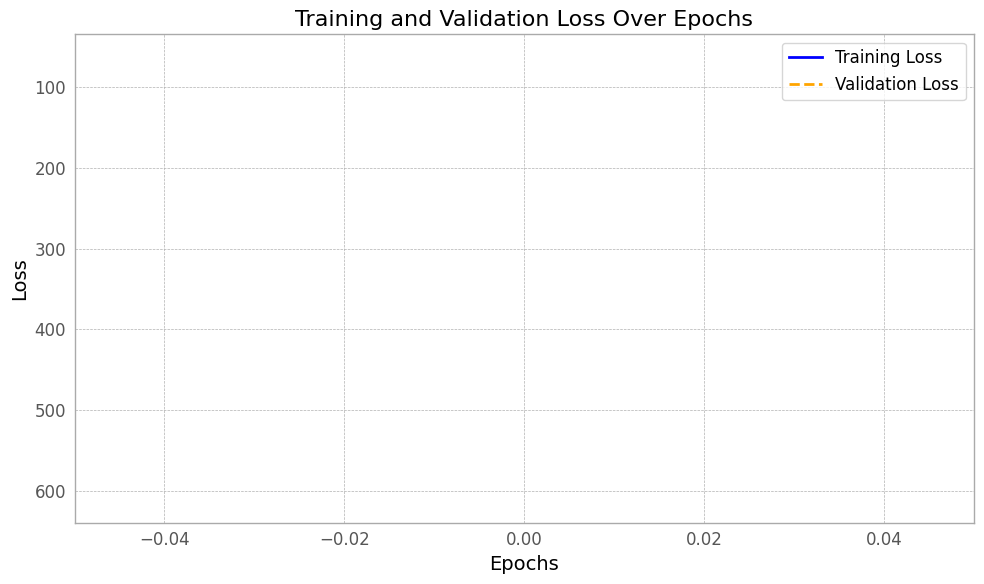

In [31]:



# Set a larger figure size
plt.figure(figsize=(10, 6))

# Plot the training and validation loss
plt.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', linestyle='--', linewidth=2, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend to differentiate between training and validation loss
plt.legend(loc='best', fontsize=12)

# Set limits for better visualization
plt.xlim(0, len(history.history['loss']) - 1)  # From epoch 0 to the last epoch
plt.ylim(min(history.history['loss']) * 0.95, max(history.history['val_loss']) * 1.05)

# Show the plot
plt.tight_layout()
plt.savefig('results/figures/' + saved_model_name.removesuffix('unet_model.keras') + '_training_validation_loss.png')
plt.show()
